In [1]:
import multiprocessing as mp
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

# For visualization
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

In [2]:
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
# a hack to import module from different directory
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Define Hyper-parameters

In [16]:
NUM_EXAMPLES = 50000  # 9k samples train, 1k for dev, 1k for dev
BLOCK_LEN = 100
SNR_MAX   = 10.0 # [0.5,1] 100 
SNR       = SNR_MAX 

modem = QAMModem(4)  # Constellation  QAM16
trellis = Trellis(memory   = np.array([2]), 
                  g_matrix = np.array([[0o7, 0o5]]) , 
                  feedback = 0o7)

In [17]:
def generate_signal_over_awgn(modem, block_length=100, snr_dB=15.0):
    message_bits   = np.random.randint(0, 2, block_length)
    encoded_bits   = cp.channelcoding.conv_encode(message_bits, trellis)
    modulated_bits = modem.modulate(encoded_bits)
    corrupted_bits = cp.channels.awgn(modulated_bits, snr_dB, rate=1/2)
    
    return message_bits, modulated_bits, corrupted_bits

def signal_generator(modulation_scheme, num_examples, block_length, snr_dB):
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.starmap(generate_signal_over_awgn,
                iterable=[(modulation_scheme, block_length, snr_dB) \
                          for i in range(num_examples)])
        orignal_msg_bits, moded_bits, noisy_outputs = zip(*result)
    return (np.array(orignal_msg_bits), np.array(moded_bits), np.array(noisy_outputs))

## Train a RNN to estimate original message over noisy AWGN channel.

### Split data into training/dev/test

* Dev and Test set should have similar distribution.
* Split into 80/10/10.
* Adopt from : https://cs230-stanford.github.io/train-dev-test-split.html

In [18]:
import random 

# Generate data for training
original_bits, clean_signals, noisy_signals = signal_generator(modem, NUM_EXAMPLES, BLOCK_LEN, SNR)

# Split data into train/dev/test
dataset = list(zip(noisy_signals, original_bits))

# Shuffle Before splitting the data
random.shuffle(dataset)
split1 = int(0.8 * len(dataset))
split2 = int(0.9 * len(dataset))
train_set = dataset[:split1]
dev_set = dataset[split1:split2]
test_set = dataset[split2:]

print(len(train_set), len(dev_set), len(test_set))

40000 5000 5000


In [19]:
def get_trainable_data(x, y):
    """Encode complex numbers to trainable data and one_hot labels"""
    x = np.array(x)[:, :100]
    y = np.array(y)
    x = np.stack((x.real, x.imag), axis=-1)
    y = np.expand_dims(y, -1)  # (batch, block_length, 1)
    return x, y

x_train, y_train = zip(*train_set)
x_dev, y_dev = zip(*dev_set)
x_test, y_test = zip(*test_set)

X_train, Y_train = get_trainable_data(x_train, y_train)
X_dev, Y_dev = get_trainable_data(x_dev, y_dev)
X_test, Y_test = get_trainable_data(x_test, y_test)

print('Training data')
print('Trainable data:', X_train.shape, X_dev.shape, X_test.shape)
print('Groundtruths  :', Y_train.shape, Y_dev.shape, Y_test.shape)

Training data
Trainable data: (40000, 100, 2) (5000, 100, 2) (5000, 100, 2)
Groundtruths  : (40000, 100, 1) (5000, 100, 1) (5000, 100, 1)


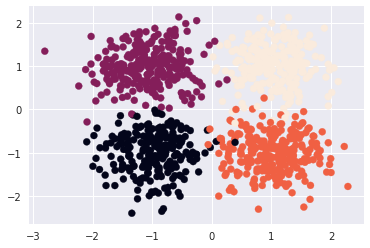

In [20]:
inputs = noisy_signals.flatten()[0:1000]
_, groundtruths = np.unique(clean_signals, return_inverse=True)
plt.scatter(np.real(inputs), np.imag(inputs), c=groundtruths[0:1000])

###  Esimate optimal performance using baseline


In [21]:
from radioml.radio_receivers import ModularReceiver
from radioml.demodulators import ClassicDemodulator
from radioml.decoders import ViterbiDecoder
from radioml.utils import get_ber_bler

classic_demod   = ClassicDemodulator(modem)
viterbi_decoder = ViterbiDecoder(trellis, tb_depth=15, decoding_type='hard')

baseline_receiver = ModularReceiver(classic_demod, viterbi_decoder)

with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_dev])

ber, bler        = get_ber_bler(np.array(baseline_estimated)[:, :100], 
                                      y_dev)
print('Optimal BER: %.4f' % ber)
print('Optimal BLER: %.5f' % bler)

Optimal BER: 0.0003
Optimal BLER: 0.01920


### Define a Recurrent  Neural network for estimating orginal message

In [22]:
## Simple Classification
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional, TimeDistributed
tf.keras.backend.clear_session()

num_hidden_layers = 2
num_hidden_units = 400
dropout_rate = 0.3


inputs  = Input(shape=(None, 2))
x = inputs
for _ in range(num_hidden_layers):
    x = Bidirectional(GRU(
        units=num_hidden_units,
        return_sequences=True,
        recurrent_dropout=dropout_rate))(x)
    x = BatchNormalization()(x)
    
outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 800)         967200    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 800)         3200      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 800)         2882400   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 800)         3200      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           801       
Total params: 3,856,801
Trainable params: 3,853,601
Non-trainable params: 3,200
______________________________________________________________

In [23]:
def BER(y, y_pred):
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.reduce_sum(hamming_distances) / tf.size(y)

def BLER(y, y_pred):
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int64)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.count_nonzero(tf.reduce_sum(hamming_distances, axis=1)) / num_blocks_per_batch

model.compile('adam','mse', metrics=[BER, BLER])
model.fit(X_train, Y_train, 
          validation_data=(X_dev, Y_dev), 
          epochs=5, batch_size=128)

Train on 40000 samples, validate on 5000 samples
Epoch 1/5
40000/40000 [==============================] - 131s 3ms/step - loss: 0.0062 - BER: 0.0077 - BLER: 0.3535 - val_loss: 0.0081 - val_BER: 0.0092 - val_BLER: 0.5914
Epoch 2/5
40000/40000 [==============================] - 131s 3ms/step - loss: 6.0238e-04 - BER: 7.1325e-04 - BLER: 0.0673 - val_loss: 4.2360e-04 - val_BER: 4.9000e-04 - val_BLER: 0.0470
Epoch 3/5
40000/40000 [==============================] - 139s 3ms/step - loss: 3.5073e-04 - BER: 3.9625e-04 - BLER: 0.0381 - val_loss: 1.9709e-04 - val_BER: 1.9000e-04 - val_BLER: 0.0188
Epoch 4/5
40000/40000 [==============================] - 135s 3ms/step - loss: 1.9851e-04 - BER: 1.9775e-04 - BLER: 0.0194 - val_loss: 1.0642e-04 - val_BER: 1.1200e-04 - val_BLER: 0.0112
Epoch 5/5
40000/40000 [==============================] - 139s 3ms/step - loss: 1.1033e-04 - BER: 1.0525e-04 - BLER: 0.0104 - val_loss: 5.0005e-05 - val_BER: 4.6000e-05 - val_BLER: 0.0046


In [24]:
with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_test])

ber, bler        = get_ber_bler(np.array(baseline_estimated)[:, :100], y_test)
print('Optimal BER: %.4f' % ber)
print('Optimal BLER: %.5f' % bler)

Optimal BER: 0.0004
Optimal BLER: 0.01940


In [25]:
# _, ber, bler = model.evaluate(X_test, Y_test)
predictions = model.predict(X_test, batch_size=512)
estimated = np.squeeze(predictions, -1).round()

ber, bler = get_ber_bler(np.array(estimated), y_test)
print('BER: %f' % ber)
print('BLER: %f' % bler)

BER: 0.000036
BLER: 0.003600


In [26]:
model.save('end2end.hdf5')